dataset from: https://www.kaggle.com/datasets/davidbroberts/piano-triads-wavset

In [117]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt

In [118]:
def load_data(data_path, metadata_path):
    features = []
    labels = []


    metadata = pd.read_csv(metadata_path)


    for index, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"{row['Chord']}.wav")


        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)

        # Check if the audio length is less than the default n_fft size
        if len(audio) < 2048:
            # Pad the audio file with zeros
            audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')



        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)


        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['Chord_modified'])


    return np.array(features), np.array(labels)



In [119]:
data_path = "/Users/chloezhao/Downloads/archive2/piano_triads/"
metadata_path = "/Users/chloezhao/summer 2024 project/summer-project/triads_modified.csv"
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


In [120]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.2, random_state=42)


In [121]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))


/Users/chloezhao/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [122]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [123]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [124]:
def make_predictions(model, le, file_path):
    audio, sample_rate = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    features = mfccs_scaled.reshape(1, mfccs_scaled.shape[0], 1)
    predicted_vector = model.predict(features)
    predicted_class_index = np.argmax(predicted_vector, axis=-1)
    return le.inverse_transform(predicted_class_index)[0]


In [125]:
# Save the initial weights
initial_weights = model.get_weights()


# Dictionary to store old predictions
old_predictions = {}
new_predictions = {}


# List of test files and their true labels
#test_files = [
    #("/Users/elaineran/Downloads/archive/fold1/101415-3-0-2.wav", "Dog bark"),
    #("/Users/elaineran/Downloads/archive/fold1/101415-3-0-3.wav", "Dog bark"),
    #("/Users/elaineran/Downloads/archive/fold1/102305-6-0-0.wav", "Gun shots"),
    #("/Users/elaineran/Downloads/archive/fold1/103074-7-0-2.wav", "Jack hammer"),
    #("/Users/elaineran/Downloads/archive/fold1/103074-7-4-3.wav", "Jack hammer")
#]


# Make predictions before training
#for file_path, true_label in test_files:
    #predicted_label_before = make_predictions(model, le, file_path)
    #old_predictions[file_path] = predicted_label_before


In [126]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.0386 - loss: 21.3297 - val_accuracy: 0.0486 - val_loss: 3.5807
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0399 - loss: 4.0287 - val_accuracy: 0.0278 - val_loss: 3.5718
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0432 - loss: 3.6672 - val_accuracy: 0.0556 - val_loss: 3.5668
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0402 - loss: 3.6226 - val_accuracy: 0.0903 - val_loss: 3.5521
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0503 - loss: 3.6053 - val_accuracy: 0.0486 - val_loss: 3.5268
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0618 - loss: 3.5588 - val_accuracy: 0.0729 - val_loss: 3.4713
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0531 - loss: 3.5284 - val_accuracy: 0.1007 - val_loss: 3.3869
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0606 - loss: 3.5062 - val_accuracy: 0.1250 - val_

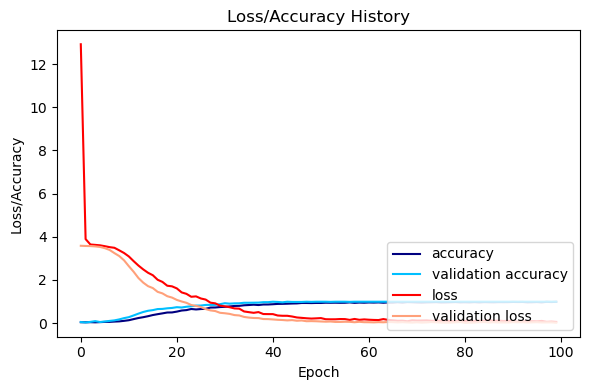

In [127]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.show()

In [128]:
test_predictions = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [129]:
predicted_class_indices = np.argmax(test_predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_class_indices)
print(predicted_classes)

['E_dim' 'E_maj' 'G_dim' 'Bb_maj' 'Gs_maj' 'E_maj' 'Eb_min' 'A_min'
 'G_min' 'E_maj' 'D_maj' 'G_min' 'B_min' 'C_maj' 'B_min' 'Cs_maj' 'G_min'
 'Fs_maj' 'Eb_min' 'Bb_min' 'Fs_min' 'D_min' 'Bb_maj' 'G_maj' 'E_min'
 'E_maj' 'Cs_min' 'A_maj' 'Gs_maj' 'A_maj' 'F_dim' 'F_maj' 'G_maj'
 'Bb_maj' 'F_dim' 'A_min' 'Gs_maj' 'A_maj' 'Cs_min' 'E_maj' 'Eb_min'
 'C_maj' 'B_maj' 'A_maj' 'Gs_maj' 'F_maj' 'B_maj' 'E_maj' 'Gs_min'
 'Fs_min' 'E_maj' 'Eb_maj' 'Cs_min' 'Eb_min' 'D_min' 'G_dim' 'B_maj'
 'B_min' 'Fs_maj' 'Gs_min' 'F_dim' 'Gs_min' 'Cs_min' 'Eb_maj' 'Gs_min'
 'A_dim' 'G_dim' 'G_maj' 'Cs_maj' 'Eb_maj' 'C_min' 'Bb_min' 'B_maj'
 'C_min' 'Cs_min' 'Cs_maj' 'Cs_dim' 'G_min' 'G_maj' 'Cs_maj' 'D_maj'
 'Cs_min' 'Eb_maj' 'C_maj' 'Gs_dim' 'Cs_dim' 'C_maj' 'B_maj' 'D_maj'
 'Bb_maj' 'D_min' 'D_min' 'Fs_min' 'B_dim' 'Bb_maj' 'Gs_maj' 'Gs_maj'
 'Bb_min' 'E_min' 'F_dim' 'A_min' 'Fs_maj' 'F_maj' 'Bb_maj' 'B_min'
 'Eb_maj' 'E_min' 'Fs_min' 'B_maj' 'C_maj' 'B_min' 'Eb_min' 'G_min'
 'Cs_maj' 'D_maj' 'Eb_min' 'Fs_ma

In [130]:
y_true = np.argmax(y_test, axis=1)
true_classes = le.inverse_transform(y_true)
print(true_classes)

['E_dim' 'E_maj' 'G_dim' 'Bb_maj' 'Gs_maj' 'E_maj' 'Eb_min' 'A_min'
 'G_min' 'E_maj' 'D_maj' 'G_min' 'B_min' 'C_maj' 'B_min' 'Cs_maj' 'G_min'
 'Fs_maj' 'Eb_min' 'Bb_min' 'Fs_min' 'D_min' 'Bb_maj' 'G_maj' 'E_min'
 'E_maj' 'Cs_min' 'A_maj' 'Gs_maj' 'A_maj' 'F_dim' 'F_maj' 'G_maj'
 'Bb_maj' 'F_dim' 'A_min' 'Gs_maj' 'A_maj' 'Cs_min' 'E_maj' 'Eb_min'
 'C_maj' 'B_maj' 'A_maj' 'Gs_maj' 'F_maj' 'B_maj' 'E_maj' 'Gs_min'
 'Fs_min' 'E_maj' 'Eb_maj' 'Cs_min' 'Eb_min' 'D_min' 'G_dim' 'B_maj'
 'B_min' 'Fs_maj' 'Gs_min' 'F_dim' 'Gs_min' 'Cs_min' 'Eb_maj' 'Gs_min'
 'A_dim' 'G_dim' 'G_maj' 'Cs_maj' 'Eb_maj' 'C_min' 'Bb_min' 'B_maj'
 'C_min' 'Cs_min' 'Cs_maj' 'Cs_dim' 'G_min' 'G_maj' 'Cs_maj' 'D_maj'
 'Cs_min' 'Eb_maj' 'C_maj' 'Gs_dim' 'Cs_dim' 'C_maj' 'B_maj' 'D_maj'
 'Bb_maj' 'D_min' 'D_min' 'Fs_min' 'B_dim' 'Bb_maj' 'Gs_maj' 'Gs_maj'
 'Bb_min' 'E_min' 'F_dim' 'A_min' 'Fs_maj' 'F_maj' 'Bb_maj' 'B_min'
 'Eb_maj' 'E_min' 'Fs_min' 'B_maj' 'C_maj' 'B_min' 'Eb_min' 'G_min'
 'Cs_maj' 'D_maj' 'Eb_min' 'Fs_ma

In [131]:
unique_labels = np.unique(np.concatenate([y_true, predicted_class_indices]))


# Calculate accuracy
accuracy = accuracy_score(y_true, predicted_class_indices)
print("Accuracy:", accuracy)


# Generate a classification report
print(classification_report(y_true, predicted_class_indices, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))


# Confusion matrix
cm = confusion_matrix(y_true, predicted_class_indices)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9895833333333334
              precision    recall  f1-score   support

       A_dim       1.00      1.00      1.00         5
       A_maj       1.00      1.00      1.00        13
       A_min       1.00      1.00      1.00        12
       B_dim       1.00      1.00      1.00         4
       B_maj       1.00      1.00      1.00         9
       B_min       1.00      1.00      1.00         9
      Bb_dim       1.00      1.00      1.00         6
      Bb_maj       1.00      1.00      1.00        11
      Bb_min       1.00      1.00      1.00        10
       C_dim       1.00      1.00      1.00         2
       C_maj       1.00      0.80      0.89        15
       C_min       1.00      1.00      1.00         7
      Cs_dim       1.00      1.00      1.00         5
      Cs_maj       1.00      1.00      1.00        10
      Cs_min       1.00      1.00      1.00         9
       D_dim       1.00      1.00      1.00         1
       D_maj       0.73      1.00      0.84         

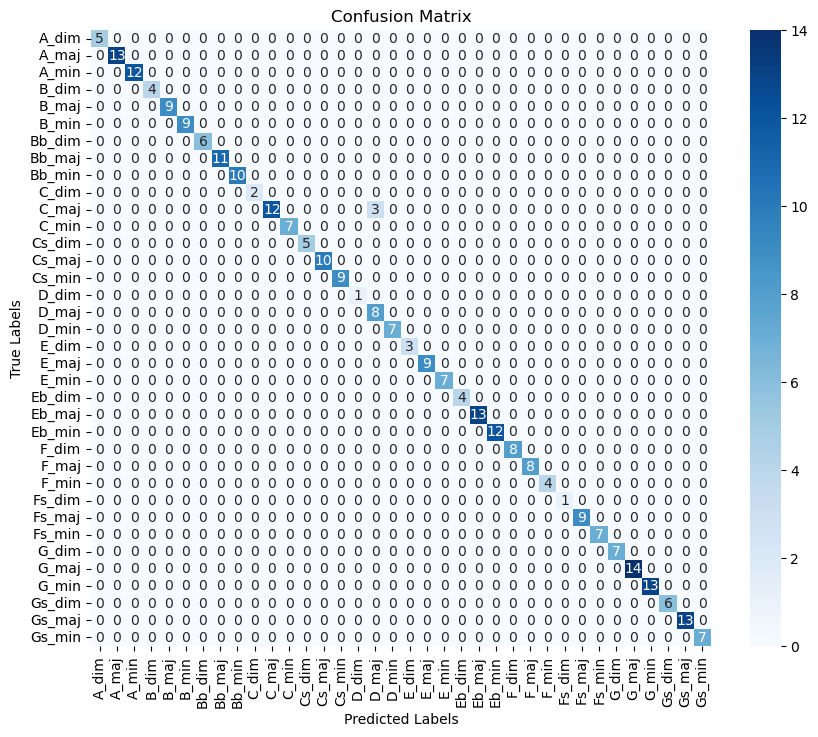

In [132]:


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
